<a href="https://colab.research.google.com/github/bir-damla/fish_classification/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
dir = "/content/drive/My Drive/dataset/kaggle_big_data_set/Fish_Dataset"
label = []
path = []
for dirname, _, filenames in os.walk(dir):
    for filename in filenames:
        if os.path.splitext(filename)[1]  in ['.png', '.jpg', '.jpeg', '.gif']:
            if dirname.split()[-1] != 'GT':
                label.append(os.path.split(dirname)[1])
                path.append(os.path.join(dirname, filename))

df = pd.DataFrame(columns=['path', 'label'])
df['path'] = path
df['label'] = label

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9036 entries, 0 to 9035
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9036 non-null   object
 1   label   9036 non-null   object
dtypes: object(2)
memory usage: 141.3+ KB


In [4]:
df['label'] = df['label'].astype('category')

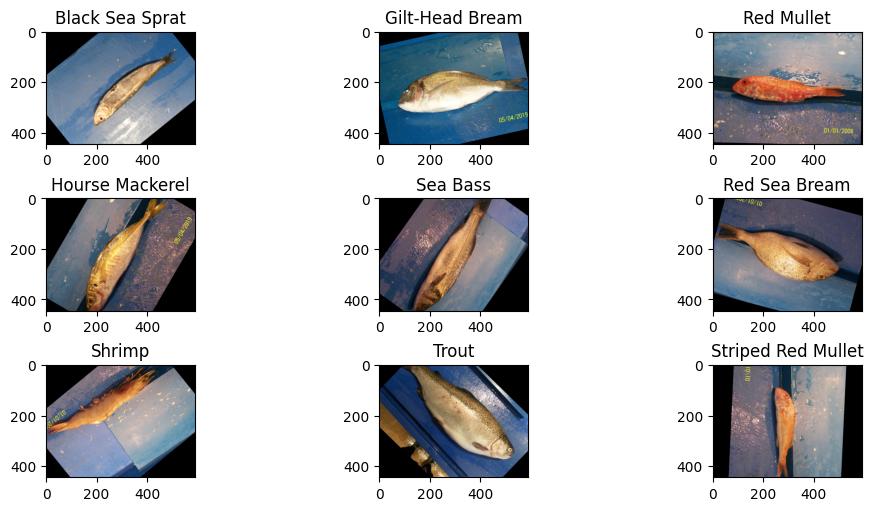

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

df['label'].unique()

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 5), constrained_layout=True)
ax = ax.flatten()
j = 0
for i in df['label'].unique():
    ax[j].imshow(plt.imread(df[df['label'] == i].iloc[0, 0]))
    ax[j].set_title(i)
    j = j + 1

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)

In [7]:
print(X_train.shape)
print(X_test.shape)

(7228, 2)
(1808, 2)


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

trainGen = ImageDataGenerator(rescale=1./255, validation_split=0.3,
                              rotation_range=30,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              horizontal_flip=True)
testGen = ImageDataGenerator(rescale=1./255)

X_train_img = trainGen.flow_from_dataframe(dataframe=X_train, x_col='path', y_col='label',
                                           class_mode='categorical', subset='training',
                                           color_mode='rgb', batch_size=64)
X_val_img = trainGen.flow_from_dataframe(dataframe=X_train, x_col='path', y_col='label',
                                         class_mode='categorical', subset='validation',
                                         color_mode='rgb', batch_size=64)
X_test_img = testGen.flow_from_dataframe(dataframe=X_test, x_col='path', y_col='label',
                                         class_mode='categorical', color_mode='rgb',
                                         batch_size=64, shuffle=False)

Found 5060 validated image filenames belonging to 9 classes.
Found 2168 validated image filenames belonging to 9 classes.
Found 1808 validated image filenames belonging to 9 classes.


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

image_shape = (256, 256, 3)

cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=image_shape))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(9, activation='softmax'))

cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3)

results = cnn_model.fit(X_train_img, epochs=30,
                        validation_data=X_val_img,
                        callbacks=[early_stop])

Epoch 1/30
80/80 [==============================] - 2607s 33s/step - loss: 1.9234 - accuracy: 0.2715 - val_loss: 1.5420 - val_accuracy: 0.4147
Epoch 2/30
80/80 [==============================] - 205s 3s/step - loss: 1.4697 - accuracy: 0.4283 - val_loss: 1.2308 - val_accuracy: 0.5226
Epoch 3/30
80/80 [==============================] - 201s 3s/step - loss: 1.1362 - accuracy: 0.5644 - val_loss: 0.9135 - val_accuracy: 0.6458
Epoch 4/30
80/80 [==============================] - 200s 3s/step - loss: 0.9925 - accuracy: 0.6119 - val_loss: 0.7773 - val_accuracy: 0.7126
Epoch 5/30
80/80 [==============================] - 200s 3s/step - loss: 0.7964 - accuracy: 0.6955 - val_loss: 0.7162 - val_accuracy: 0.7542
Epoch 6/30
80/80 [==============================] - 197s 2s/step - loss: 0.6315 - accuracy: 0.7745 - val_loss: 0.5673 - val_accuracy: 0.7994
Epoch 7/30
80/80 [==============================] - 199s 2s/step - loss: 0.6082 - accuracy: 0.7818 - val_loss: 0.3932 - val_accuracy: 0.8635
Epoch 8/30


In [10]:
cnn_model.save("cnn_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# test verileri


In [11]:
predictions = cnn_model.predict(X_test_img)
pred_cnn = np.argmax(predictions, axis=1)

29/29 [==============================] - 597s 21s/step


In [12]:
pred_df_cnn = X_test.copy()
labels = {v: k for k, v in X_test_img.class_indices.items()}
pred_df_cnn['pred'] = pred_cnn
pred_df_cnn['pred'] = pred_df_cnn['pred'].apply(lambda x: labels[x])

Accuracy Score: 0.9789823008849557
F1 Score: 0.9788302425272554
                    precision    recall  f1-score   support

   Black Sea Sprat       0.97      1.00      0.98       195
   Gilt-Head Bream       0.99      0.91      0.95       214
   Hourse Mackerel       0.98      0.99      0.99       199
        Red Mullet       1.00      0.98      0.99       187
     Red Sea Bream       0.96      0.99      0.98       201
          Sea Bass       0.95      0.96      0.95       202
            Shrimp       0.99      0.99      0.99       198
Striped Red Mullet       0.97      1.00      0.99       206
             Trout       1.00      1.00      1.00       206

          accuracy                           0.98      1808
         macro avg       0.98      0.98      0.98      1808
      weighted avg       0.98      0.98      0.98      1808



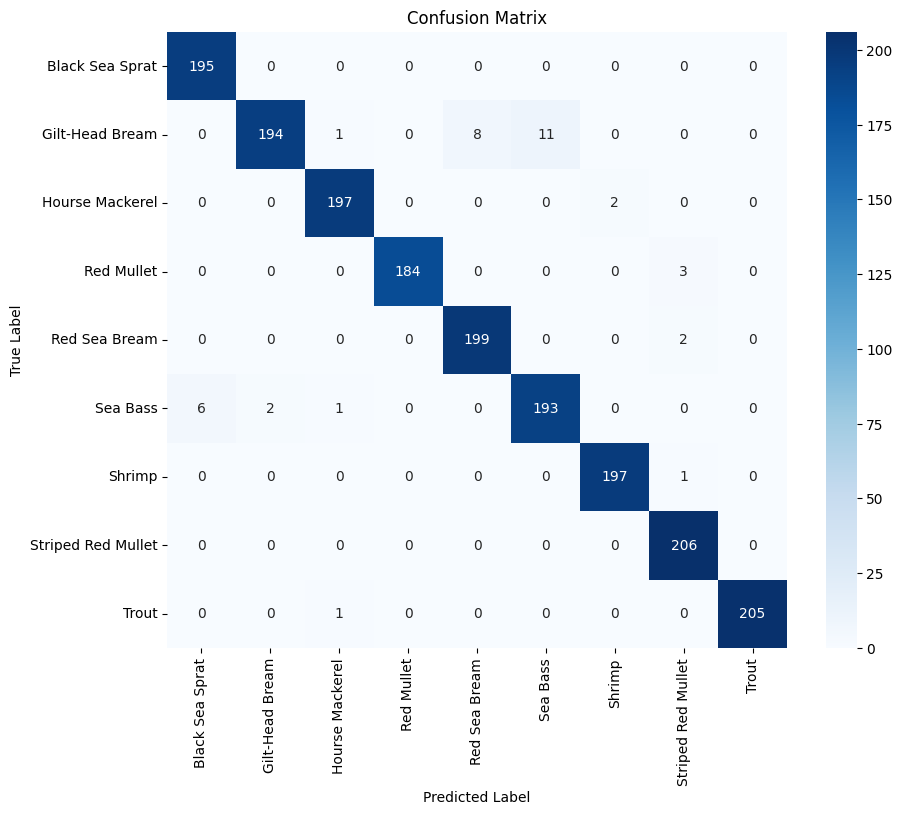

In [13]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder

true_labels_cnn = pred_df_cnn['label']
pred_labels_cnn = pred_df_cnn['pred']

accuracy = accuracy_score(true_labels_cnn, pred_labels_cnn)
print(f"Accuracy Score: {accuracy}")

f1 = f1_score(true_labels_cnn, pred_labels_cnn, average='weighted')
print(f"F1 Score: {f1}")

print(classification_report(true_labels_cnn, pred_labels_cnn))

cm = confusion_matrix(true_labels_cnn, pred_labels_cnn)

le = LabelEncoder()
le.fit(true_labels_cnn)
class_names = le.classes_

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

                                                   path               label  \
8645  /content/drive/My Drive/dataset/kaggle_big_dat...  Striped Red Mullet   
1318  /content/drive/My Drive/dataset/kaggle_big_dat...     Gilt-Head Bream   
7682  /content/drive/My Drive/dataset/kaggle_big_dat...               Trout   
6192  /content/drive/My Drive/dataset/kaggle_big_dat...              Shrimp   
8473  /content/drive/My Drive/dataset/kaggle_big_dat...  Striped Red Mullet   
5889  /content/drive/My Drive/dataset/kaggle_big_dat...       Red Sea Bream   

                    pred  
8645  Striped Red Mullet  
1318     Gilt-Head Bream  
7682               Trout  
6192              Shrimp  
8473  Striped Red Mullet  
5889       Red Sea Bream  


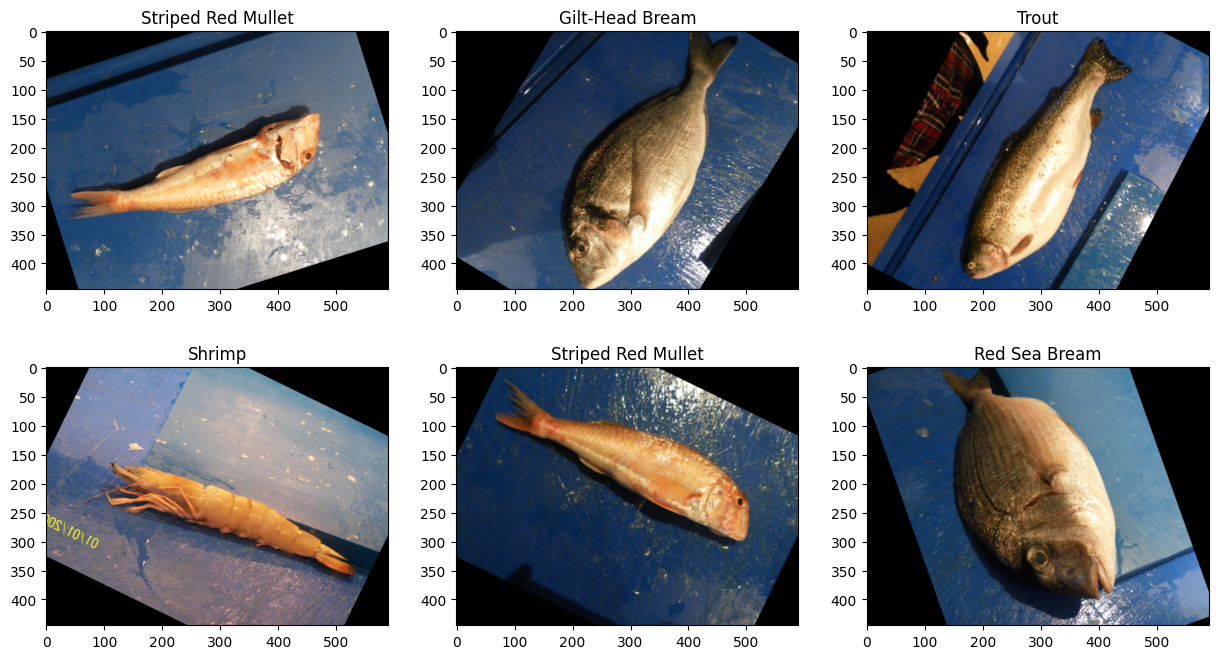

In [14]:
print(pred_df_cnn[pred_df_cnn['label'] == pred_df_cnn['pred']].head(6))
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
ax = ax.flatten()
imlist = pred_df_cnn[pred_df_cnn['label'] == pred_df_cnn['pred']].head(6).reset_index()
for i in range(6):
    ax[i].imshow(plt.imread(imlist['path'][i]))
    ax[i].set_title(imlist['label'][i])